We will gather the Tweets posted from the US House Representatives of 2020 in a selected period of time. 

Our goal is to analyze the retweets and mentions of each representative, both from the Democrat and the Republican party.

...

In [1]:
!pip3 install Counter

  Created wheel for Counter: filename=Counter-1.0.0-cp36-none-any.whl size=5396 sha256=13cc331b10a20c6a129d29fe6e4b0dc0f71a2ec131cca25fc297d37099c4ca15
  Stored in directory: /root/.cache/pip/wheels/06/16/20/5f223d85f959078fee0f6f769c6aa32a6f653d9449c1b205c3
Successfully built Counter


# Twitter API

## Import libraries

In [2]:
!pip install community

In [3]:
import os
#import twitter
import pandas as pd
import regex as re
import networkx as nx
import csv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from fa2 import ForceAtlas2
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
import string
import operator
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
# import community as community_louvain
from collections import Counter
import matplotlib
import matplotlib.colors as mcolors

## Authorize twitter

In [4]:
#Secret keys to use the twitter API

consumer_key='JwBGzHlJImbq65zdSbD2t77SC'
consumer_secret='HSStuFy7OpXg35GW4N7iobVDkSvevVmMYkAeC9BJQ0Kl4SNVW2'
access_token_key='1326184476611842050-y74nowqvPo314THVipXtQ5A95DMcHY'
access_token_secret='L6vUq7co4Pstpfzc45wuCyxy4c34DKqQ3xxahH10lgWAl'

In [5]:
#First, let's use the twitter API in order to scrap data
api = twitter.Api(consumer_key=consumer_key,
                    consumer_secret=consumer_secret,
                    access_token_key=access_token_key,
                    access_token_secret=access_token_secret)

NameError: ignored

# List of US representatives

In [ ]:
#From the list of US representatives for 2020 we obtain the `Party`, `TwitterUsernames`, `Name`, etc..

with open('./2020 representatives list.csv', newline='', encoding="utf8") as f:
    reader = csv.reader(f)
    data = list(reader)

Party = []
TwitterUsernames = []
Names = []
State = []
Chamber = []

for line in data:
    if line[4] != "":
        TwitterUsernames.append(line[4].replace("@",""))
        Names.append(line[2])
        Chamber.append(line[1])
        State.append(line[0])
        if line[3] == "R":
            Party.append("Republican")
        else:
            Party.append("Democrat")

#Print an example of a Twitter Username
print(TwitterUsernames[17])

In [ ]:
#checking the size of each our attributes

print(len(TwitterUsernames))
print(len(Party))
print(len(Names))
print(len(Chamber))
print(len(State))

## Create the DataFrame

In [ ]:
#Let's create the DataFrame with the 

Data = pd.DataFrame()

#the 1st row is the names of the list
Party.pop(0),State.pop(0),Chamber.pop(0),Names.pop(0),TwitterUsernames.pop(0) #drop the index

Data['Party'] = Party
Data['Name'] = Names
Data['State'] = State
Data['Chamber'] = Chamber
Data['TwitterUsernames'] = TwitterUsernames

In [ ]:
Data.head()

## Get the Tweets of each representative from their Timeline

In [ ]:
Timelines1 = []
for name in TwitterUsernames[0:100]:
    Timelines1.append(api.GetUserTimeline(screen_name=name, count=200)) #200 tweets

Timelines2 = []
for name in TwitterUsernames[100:200]:
    Timelines2.append(api.GetUserTimeline(screen_name=name, count=200))

Timelines3 = []
for name in TwitterUsernames[200:300]:
    Timelines3.append(api.GetUserTimeline(screen_name=name, count=200))

Timelines4 = []
for name in TwitterUsernames[300:400]:
    Timelines4.append(api.GetUserTimeline(screen_name=name, count=200))

Timelines5 = []
for name in TwitterUsernames[400:]:
    Timelines5.append(api.GetUserTimeline(screen_name=name, count=200))

#combining all the timelines together, form on dataset w tweets 
Timelines = []
Timelines = Timelines1 + Timelines2 + Timelines3 + Timelines4 + Timelines5

#NO OLD tweets so make a time limit or use the time attribute in the tweet status

Let's grab all the content of the tweets into the `ListOftxt` list.

In [ ]:
ListOftxt=[]

for timeline in Timelines:
    fullTxt=''

    for tweet in timeline:
        fullTxt += tweet.text
        
    ListOftxt.append(fullTxt)

Data['Tweets']=ListOftxt

In [ ]:
Data.head(10)

Save the dataset with the tweets to the `Data.csv` file

In [ ]:
# Data.to_csv(r'Data_new_2.csv')

In [7]:
Data = pd.read_csv('./Data.csv')

In [8]:
Party = Data['Party'] 
Names = Data['Name'] 
State = Data['State']
Chamber = Data['Chamber']
TwitterUsernames = Data['TwitterUsernames']

Now lets build the graph w/ edges the @mentions and RT's that mention other members of the US 2020 Representatives.

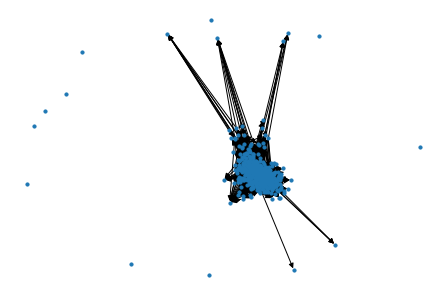

In [9]:
G = nx.DiGraph()
regex_mentions_retweets = "\s([@][\w_-]+)"
for i in range(len(Data)):
    name = Data["TwitterUsernames"][i]
    G.add_node(name, Party=Data["Party"][i], Tweets=Data["Tweets"][i])  # new entry of representative in the graph
    usernames_before = re.findall(regex_mentions_retweets, Data["Tweets"][i])
    for username in usernames_before:
        username = username.strip().split('@')[1]
        if (username in Data["TwitterUsernames"].values) and (username != name):  # usernames / candidates
            G.add_edge(name, username)
nx.draw(G, node_size=10)

# Network Graph

## Undirected 

In [ ]:
nx.draw(G, node_size=10)

## Giant connected component (GCC)

In [10]:
largest_cc = max(nx.weakly_connected_components(G), key=len)
GCC = G.subgraph(largest_cc)

## Number of Links/ Edges

In [ ]:
print("There are {} links in the network.".format(GCC.number_of_edges()))

## Number of Nodes

In [ ]:
print("There are {} nodes in the network.".format(GCC.number_of_nodes()))

## Number of links connecting the representatives from Republicans and Democrats

In [ ]:
#right now the senators are in the graph !

between_representatives = 0

for edge in GCC.edges:
    if GCC.nodes[edge[0]]['Party'] != GCC.nodes[edge[1]]['Party']:
        between_representatives += 1

print(f'Number of links between the representatives: {between_representatives}')    
print(f'Percentage of links between the representatives: {round(between_representatives/GCC.number_of_edges()*100,1)} %')    

##  5 most connected in-degree representatives

In [ ]:
in_deg = []
for i in G.nodes:
    in_deg.append(G.in_degree(i))
    
index_max_in = sorted(range(len(in_deg)), reverse=True, key=lambda k: in_deg[k])

node_names = []
for i in G.nodes:
    node_names.append(i)

index_max_in = index_max_in[0:5]

print('The 5 most connected in-degree representatives are:\n')

for i in range(len(index_max_in)):
    index = index_max_in[i]
    print(node_names[index])

##  5 most connected out-degree representatives

In [ ]:
out_deg = []
for i in G.nodes:
    out_deg.append(G.out_degree(i))

index_max_out = sorted(range(len(out_deg)), reverse=True, key=lambda k: out_deg[k])

index_max_out = index_max_out[0:5]

print('The 5 most connected out-degree representatives are:\n')

for i in range(len(index_max_out)):
    index = index_max_out[i]
    print(node_names[index])

## In and out-degree distributions

In [ ]:
def distribution_graph(G, mode):
    # find in or out degrees of network
    if mode.lower() == 'in':
        degree_sequence = [d for n, d in G.in_degree()]
    else:
        degree_sequence = [d for n, d in G.out_degree()]
    # find min and max of degrees     
    dmax = max(degree_sequence)
    dmin = min(degree_sequence)
    
    # compute frequencies of degrees distribution
    counts, bins = np.histogram(degree_sequence, bins = np.arange(dmin-0.5, dmax+1.5,1))
    
    sns.set()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [15,5])
    fig.suptitle(mode+'-degree distribution')

    ax1.bar(np.arange(dmin, dmax+1,1), counts, color='midnightblue')
    ax1.set_xlim(-1, 60)
    ax1.set_ylim(0, 200)
    ax1.set_xlabel('node degree')
    ax1.set_ylabel('count')

    ax2.loglog(np.arange(dmin, dmax+1,1), counts, 'o', color='midnightblue')
    ax2.set_xlim(0.5, 10**3)
    ax2.set_ylim(0.5, 10**3)
    ax2.set_xlabel('log(node degree)')
    ax2.set_ylabel('log(count)')
    plt.show()
    
distribution_graph(GCC,'In')
distribution_graph(GCC,'Out')

In [ ]:
#no pplot in and out degree distr

# Network Graph

In [11]:
# Convert to undirected graph
GU = GCC.to_undirected()

# Color nodes according to party
colors = []
for n in list(GU.nodes(data="Party")):
    if 'Republican' in n:
        colors.append('red')
    else:
        colors.append('blue') 

# Scale node-size according to degree
d = nx.degree(GU)
sizes = [(d[node]+1) * 5 for node in GU.nodes()]

# Color edges according to between-party or not
edge_colors = []
for edge in GU.edges:
    if GU.nodes[edge[0]]['Party'] != GU.nodes[edge[1]]['Party']:
        edge_colors.append('grey')
    else:
        if GU.nodes[edge[0]]['Party'] == 'Republican':
            edge_colors.append('red')
        else: 
            edge_colors.append('blue')
            
# Specify the settings for the Force Atlas 2 algorithm
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=7.0,

                        # Performance
                        jitterTolerance=0.5,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=40,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.5,
                        strongGravityMode=False,
                        gravity=0,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(GU, pos=None, iterations=4000)

100%|██████████| 4000/4000 [00:06<00:00, 633.68it/s]

BarnesHut Approximation  took  4.30  seconds
Repulsion forces  took  0.10  seconds
Gravitational forces  took  0.09  seconds
Attraction forces  took  0.86  seconds
AdjustSpeedAndApplyForces step  took  0.47  seconds


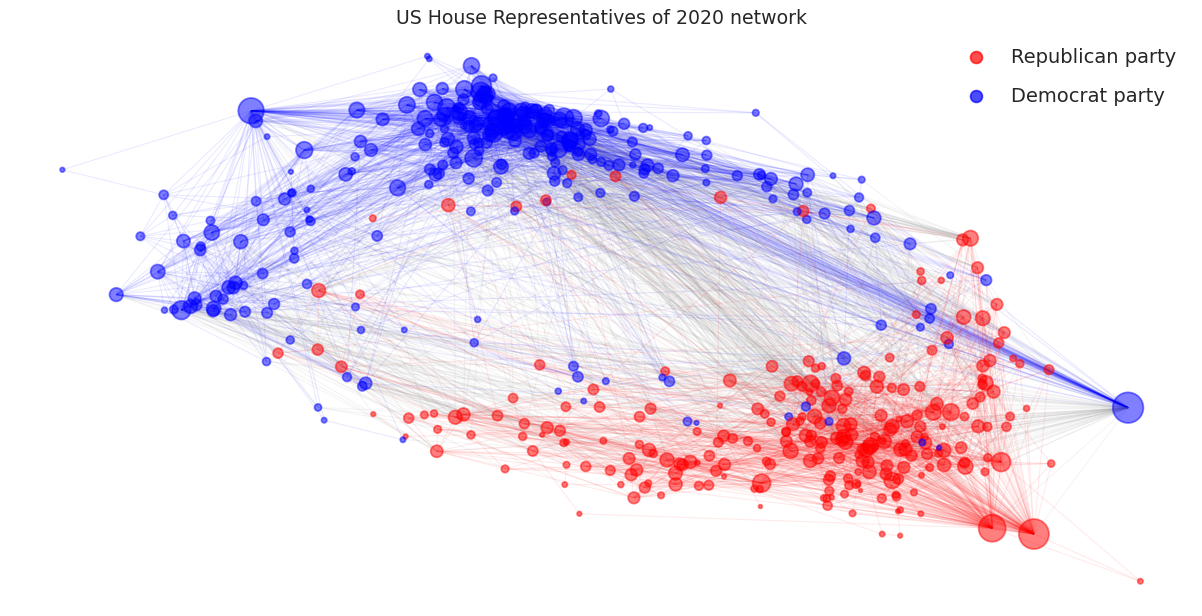

In [12]:
plt.figure(num=None, figsize=(18,9), dpi=85, facecolor='w', edgecolor='k')

sns.set_style('whitegrid')
sns.set_context('talk')

# create legend
plt.scatter([], [], c='red', alpha=0.7, s=100, label='Republican party')
plt.scatter([], [], c='blue', alpha=0.7, s=100, label='Democrat party')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1)

nx.draw_networkx_nodes(GU, positions, node_size = sizes, node_color = colors, alpha = 0.5)
nx.draw_networkx_edges(GU, positions, edge_color = edge_colors, alpha = 0.08)
ax = plt.gca()
ax.collections[0].set_linewidth(0.1) 
ax.set_title('US House Representatives of 2020 network', fontsize = 16);
plt.axis('off')
plt.show()

#Notes

Who each representative mentioned the most from the same party? Who from the other one?

Most popular hashtags each party used

In [13]:
full_republican_text = ' '.join(Data[Data["Party"] == "Republican"]["Tweets"])
full_democrat_text = ' '.join(Data[Data["Party"] == "Democrat"]["Tweets"])

print(f'Length of full Republican text: {len(full_republican_text)}.')
print(f'Length of full Democrats text: {len(full_democrat_text)}.')

Length of full Republican text: 6491461.
Length of full Democrats text: 7433879.


In [14]:
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer() #assign the lemmatization function to a variable
pun = string.punctuation #assign to a string all sets of punctuation
stops = nltk.corpus.stopwords.words('english') #assign the list of english stop words (commonly used words)

cleaned_republican_text = []

words = full_republican_text.split(' ') #returns a tokenized copy of each line
words = [w.lower() for w in words] #all characters are set to lower case
words = [word for word in words if not word.startswith("@")]
words = [word for word in words if not word in pun] #keep only the words which don't contain any of the listed punctuations
words = [word for word in words if word.isalpha()] #keep the words which contain only alphabet letters
words = [w for w in words if not w in stops] #removes the english stop words
words = [w for w in words if not len(w) == 1] #removes the words which have length equal to 1
for word in words: #loop through the list of words
    word = lemmatizer.lemmatize(word) #return the lemma of each word
    cleaned_republican_text.append(word) #write each word to the cleaned dc-file
    
    
cleaned_democrat_text = []

words = full_democrat_text.split(' ') #returns a tokenized copy of each line
words = [w.lower() for w in words] #all characters are set to lower case
words = [word for word in words if not word.startswith("@")]
words = [word for word in words if not word in pun] #keep only the words which don't contain any of the listed punctuations
words = [word for word in words if word.isalpha()] #keep the words which contain only alphabet letters
words = [w for w in words if not w in stops] #removes the english stop words
words = [w for w in words if not len(w) == 1] #removes the words which have length equal to 1
for word in words: #loop through the list of words
    word = lemmatizer.lemmatize(word) #return the lemma of each word
    cleaned_democrat_text.append(word) #write each word to the cleaned dc-file

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [15]:
len(cleaned_republican_text)

347182

In [16]:
len(cleaned_democrat_text)

400681

In [17]:
fdist_republican = nltk.FreqDist(cleaned_republican_text)

In [18]:
fdist_democrat = nltk.FreqDist(cleaned_democrat_text)

In [19]:
print('The 5 most common words in the Republicans text:')
print(fdist_republican.most_common(5))

print('\nThe 5 most common words in the Democrats text:')
print(fdist_democrat.most_common(5))

The 5 most common words in the Republicans text:
[('american', 2494), ('great', 1796), ('today', 1510), ('day', 1455), ('new', 1414)]

The 5 most common words in the Democrats text:
[('american', 2906), ('trump', 2473), ('need', 2458), ('health', 2236), ('day', 2187)]


In [20]:
#TF-TR computation for DC

tftr_republican = [] #create a list which will contain the TF-TR results for the DC universe

for token in fdist_republican: #loop through each token in term frequency
    tr = fdist_republican[token]/(fdist_democrat[token]+1) #compute the term ratios based on the above equation 
    tftr = fdist_republican[token] * tr #multiply TF and TR of each token to compute TR-TR
    tftr_republican.append([token, int(round(tftr))]) #assign the result of each token in the list (rounded up to the nearest integer value)
    
tftr_republican = sorted(tftr_republican, key = operator.itemgetter(1), reverse=True) #descending sort the list based on the TF-TR value

print(tftr_republican[:10]) #show the first 10 tokens in DC universe with the highest TF-TR value

[['communist', 19208], ['pelosi', 9041], ['socialist', 7225], ['liberal', 5249], ['great', 3604], ['arkansas', 3600], ['lahood', 3249], ['idaho', 2883], ['democrat', 2877], ['nancy', 2856]]


In [21]:
#TF-TR computation for DC

tftr_democrat = [] #create a list which will contain the TF-TR results for the DC universe

for token in fdist_democrat: #loop through each token in term frequency
    tr = fdist_democrat[token]/(fdist_republican[token]+1) #compute the term ratios based on the above equation 
    tftr = fdist_democrat[token] * tr #multiply TF and TR of each token to compute TR-TR
    tftr_democrat.append([token, int(round(tftr))]) #assign the result of each token in the list (rounded up to the nearest integer value)
    
tftr_democrat = sorted(tftr_democrat, key = operator.itemgetter(1), reverse=True) #descending sort the list based on the TF-TR value

print(tftr_democrat[:10]) #show the first 10 tokens in DC universe with the highest TF-TR value

[['transgender', 11025], ['trump', 8401], ['latino', 6273], ['health', 6016], ['coon', 5512], ['aca', 5379], ['nh', 5329], ['latinas', 5041], ['need', 4640], ['enrollment', 4620]]


In [22]:
#DC string

all_republican = '' #create the dc string

for tftr in tftr_republican: #loop through the DC TF-TR list values
    all_republican = all_republican + ((tftr[0]+' ')*tftr[1]) #add to the string the repeated tokens

In [23]:
#Marvel string

all_democrat = '' #create the marvel string

for tftr in tftr_democrat: #loop through the Marvel TF-TR list values
    all_democrat = all_democrat + ((tftr[0]+' ')*tftr[1]) #add to the string the repeated tokens

In [24]:
mask_republican = np.array(Image.open("republican.png"))
mask_democrat = np.array(Image.open("democrat.png"))

wc_republican = WordCloud(background_color="white", mask=mask_republican, contour_width=3, contour_color='darkred',
               max_font_size=1500, collocations = False)
wc_democrat = WordCloud(background_color="white", mask=mask_democrat, contour_width=3, contour_color='steelblue',
               max_font_size=1500, collocations = False)

wc_republican.generate(all_republican)
wc_democrat.generate(all_democrat)

image_colors_republican = ImageColorGenerator(mask_republican)
image_colors_democrat = ImageColorGenerator(mask_democrat)

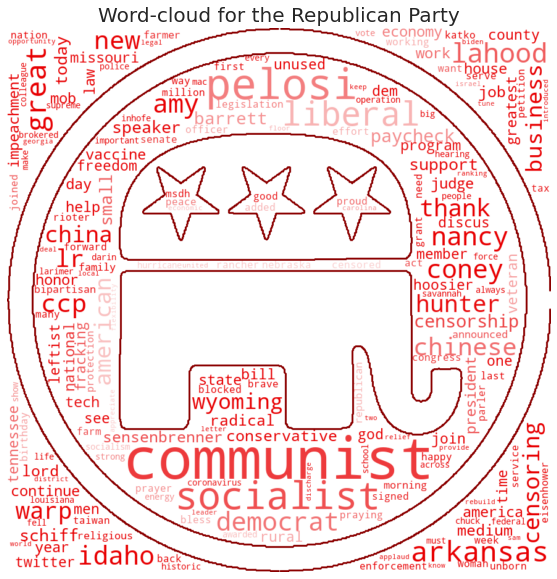

Text(0.5, 1.0, 'Word-cloud for the Democrat Party')

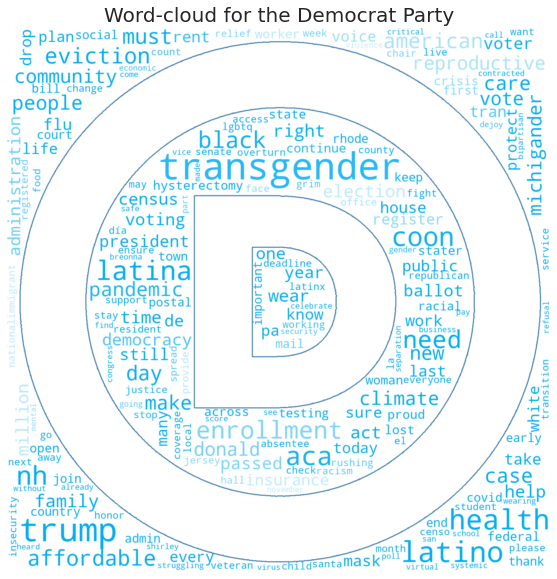

In [25]:
fig = plt.figure(figsize = (17,10))

plt.imshow(wc_republican.recolor(color_func=image_colors_republican), interpolation="bilinear")
plt.axis("off")
plt.title("Word-cloud for the Republican Party", fontsize = 20)
plt.show()

fig = plt.figure(figsize = (17,10))

plt.imshow(wc_democrat.recolor(color_func=image_colors_democrat), interpolation="bilinear")
plt.axis("off")
plt.title("Word-cloud for the Democrat Party", fontsize = 20)
#plt.show()

## Communities

In [141]:
#Republican Graph

nodes = (
    node
    for node, data in GU.nodes(data=True)
        if data.get("Party") == "Republican"
)

GU_Republican = GU.subgraph(nodes)

In [142]:
#Republican Graph

nodes = (
    node
    for node, data in GU.nodes(data=True)
        if data.get("Party") == "Democrat"
)

GU_Democrat = GU.subgraph(nodes)

In [143]:
from community import community_louvain

partition_Republican = community_louvain.best_partition(GU_Republican)

In [144]:
partition_Democrat = community_louvain.best_partition(GU_Democrat)

In [145]:
print("The total found communities for Republicans are: ", max(partition_Republican.values()) + 1)
print("The total found communities for Democrats are: ", max(partition_Democrat.values()) + 1)

The total found communities for Republicans are:  8
The total found communities for Democrats are:  10


In [146]:
communities_R = {} #create a dictionary in which we will have for each community its size and its list of heroes
count = [] #list with the size of the 11 communities

for val in set(partition_Republican.values()): #loop through the unique identified communities
    chars = [] #list with the heroes in each community
    for key in partition_Republican.keys(): #loop through all the heroes
        if partition_Republican[key] == val: #if the current community is the same as the hero's community we append it to the list 
            chars.append(key)
            
    count.append(len(chars)) #count the total number of heroes in each community - the community size
    
    communities_R[val] = len(chars), chars #assign to the dictionary the size and the different heroes in each community

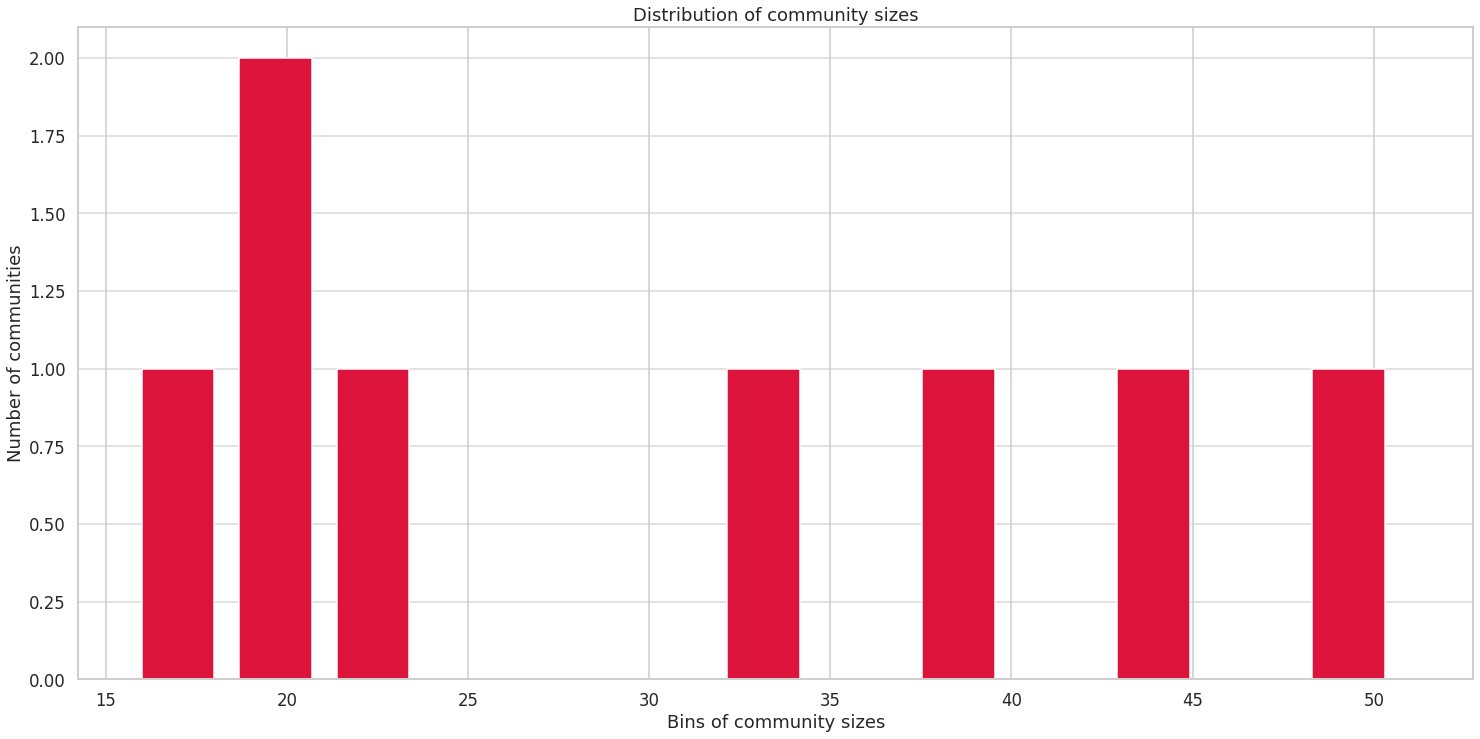

In [147]:
#create histogram for the community sizes with 6 bins 
plt.figure(figsize = (25,12))
plt.hist(count, bins=13, width=2, color='#DC143C')
plt.ylabel('Number of communities')
plt.xlabel('Bins of community sizes')
plt.title("Distribution of community sizes")
plt.grid(axis='y', alpha=0.75)

In [148]:
communities_D = {} #create a dictionary in which we will have for each community its size and its list of heroes
count = [] #list with the size of the 11 communities

for val in set(partition_Democrat.values()): #loop through the unique identified communities
    chars = [] #list with the heroes in each community
    for key in partition_Democrat.keys(): #loop through all the heroes
        if partition_Democrat[key] == val: #if the current community is the same as the hero's community we append it to the list 
            chars.append(key)
            
    count.append(len(chars)) #count the total number of heroes in each community - the community size
    
    communities_D[val] = len(chars), chars #assign to the dictionary the size and the different heroes in each community

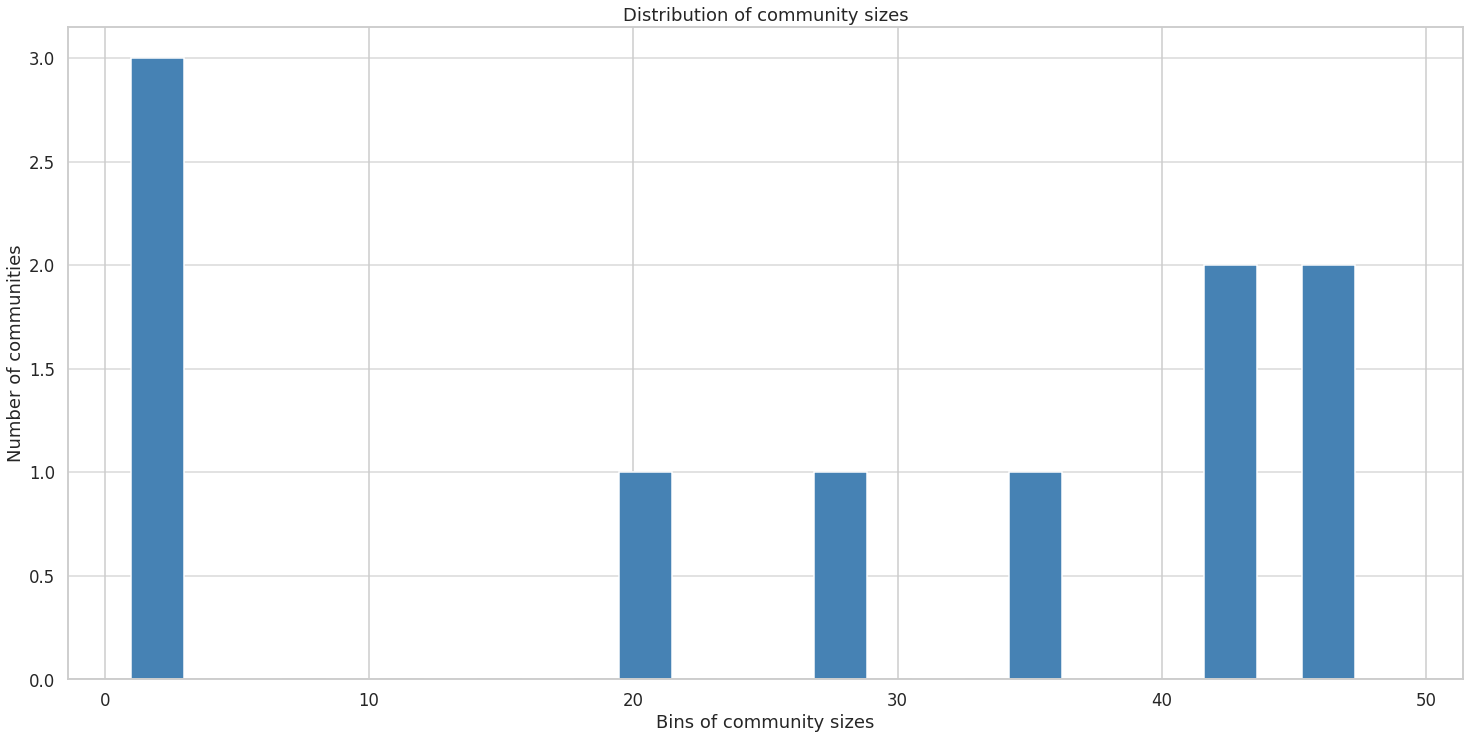

In [149]:
#create histogram for the community sizes with 6 bins 
plt.figure(figsize = (25,12))
plt.hist(count, bins=13, width=2, color='steelblue')
plt.ylabel('Number of communities')
plt.xlabel('Bins of community sizes')
plt.title("Distribution of community sizes")
plt.grid(axis='y', alpha=0.75)

* **For the 5-10 largest communities, create TF-IDF based rankings of words in each community. There are many ways to calculate TF-IDF, explain how you've done it and motivate your choices.**

In [150]:
communities_sorted = {k: v for k, v in sorted(communities_R.items(), key=lambda item: item[1], reverse=True)} #sort the dictionary based on the community size

largest_com_R = {} #create dictionary for the 6 largest communities
c=0
for key, value in communities_sorted.items(): #loop through the items in the sorted list
    if c < 6: #until we have filled the list with the items of the 6 largest community 
        largest_com_R[key] = value
    c += 1

Now, we will create a different **txt file for each community** which will contain cleaned content of each hero's wiki-page and, also, we will compute the **Term-Frequency (TF)** for each token each community has.

In [87]:
for i in largest_com_R[0][1]:
  print(i)

SenCoryGardner
RepKenBuck
RepBenCline
RepLeeZeldin
RepBlaine
RepRiggleman
JamesComer
RandPaul
RepDougCollins
Donald_McEachin
SteveScalise
RepTipton
congbillposey
RepBrianBabin
MattGaetz
RobWittman
SteveKingIA
RepCloudTX
TXRandy14
replouiegohmert
RepAlexMooney
RepJoeNeguse
RepThomasMassie
RepMcKinley
RepChipRoy
RepRussFulcher
RepGarretGraves
Lancegooden
WarrenDavidson
RepGregSteube
RepMarkGreen
GReschenthaler
RepBillFlores
DesJarlaisTN04
CaptClayHIggins
RepAnnWagner
JimPressOffice
USRepLong
RepDanCrenshaw
Jim_Jordan
RepJeffDuncan
RepDLamborn
virginiafoxx
RepCarolMiller
CongressmanHice


In [151]:
fdist_com  = [] #list with the frequency distribution (term frequency) - the frequency of each token within each community
tokens_com = {} #dictionary with the unique tokens each community has
all_tokens = [] #list with all the unique tokens from all the communities

for key,value in largest_com_R.items(): #loop through the largest communities
    com_name = 'community_'+str(key) #assign to a variable the community name
    print(com_name)
    tokens = [] #list which will contain the tokens of each community
    tokens_com[com_name] = {}
    for republican in value[1]:
        words = (''.join(Data[Data['TwitterUsernames'] == republican]["Tweets"])).split(' ')
        words = [w.lower() for w in words] #all characters are set to lower case
        words = [word for word in words if not word.startswith("@")]
        words = [word for word in words if not word in pun] #keep only the words which don't contain any of the listed punctuations
        words = [word for word in words if word.isalpha()] #keep the words which contain only alphabet letters
        words = [w for w in words if not w in stops] #removes the english stop words
        words = [w for w in words if not len(w) == 1] #removes the words which have length equal to 1
        for word in words: #loop through the list of words
            word = lemmatizer.lemmatize(word) #return the lemma of each word
            tokens.append(word) #new entry in the tokens list which will be used for the frequency distribution
            all_tokens.append(word) #new entry the total token list
                        
    tokens_com[com_name] = set(tokens) #add the unique list of tokens in each community
            
    fdist_com.append([com_name, nltk.FreqDist(tokens)]) #add the community and the term frequency of each token
                
all_tokens = set(all_tokens) #keep the unique tokens

community_0
community_6
community_2
community_5
community_3
community_7


The next step is to compute the **Inverse Document Frequency (IDF)** for each token. The IDF is computed by the following [equation](https://en.wikipedia.org/wiki/Tf%E2%80%93idf#Inverse_document_frequency):

$$ IDF[token] = \log(\frac{\text {Total number of documents}} {\text{Number of documents where the token appears}}) $$



In [152]:
import math
N = len(tokens_com) #total number of communities
idf = {} #dictionary in which we will have the IDF value for each token

for token in all_tokens: #loop through all unique tokens
    count = 0
    for key in tokens_com.keys(): #loop through each community
        if [val for val in tokens_com[key]].count(token) > 0: #if the token appears more than once in the current community 
            count += 1 #the count value will be increased by 1
            continue
            
    idf[token] = math.log(N/count) #idf computation based on the above mentioned equation

Finally, we can compute the TF-IDF value of each token by multiplying the TF and the IDF values.

In [153]:
tfidf_com = {} #dictionary in which we will have the token and the tfidf
for dist in fdist_com: #loop through each community
    tfidf_com[dist[0]] = {}
    for token in dist[1]: #loop through the tokens of the current community
        tfidf = dist[1][token] * idf[token] #calculate the tfidf
        tfidf_com[dist[0]][token] = int(round(tfidf)) #assign the rounded up to the nearest integer value

* **Create a word-cloud displaying the most important words in each community (according to TF-IDF). Comment on your results (do they make sense according to what you know about the superhero characters in those communities?)**

In order to create the word-clouds we create a long string for each community which contains their tokens repeated according to their TF-IDF score.

In [154]:
all_com = {} #dictionary which will contain the community and its long string

for com in tfidf_com:
    all_com[com] = '' #create the community's string
    for token in tfidf_com[com]: #loop through the token's TF-IDF list values
        all_com[com] = all_com[com] + (token+' ')*tfidf_com[com][token] #add to the string the repeated tokens

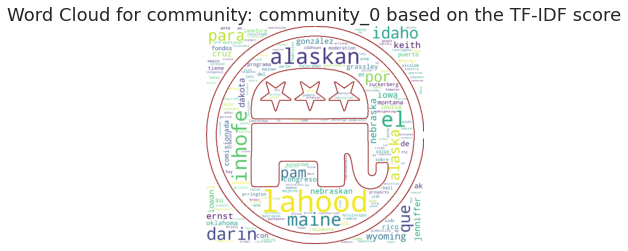

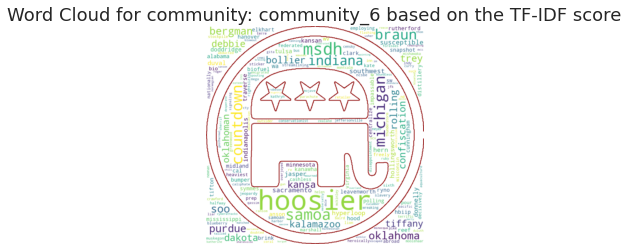

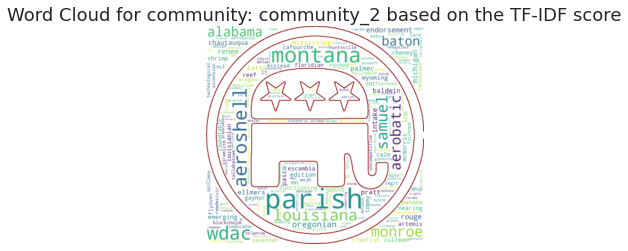

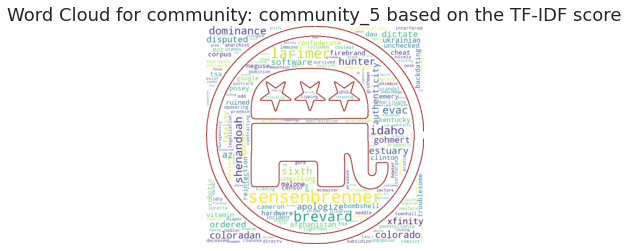

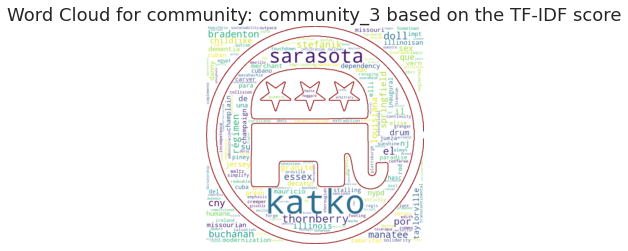

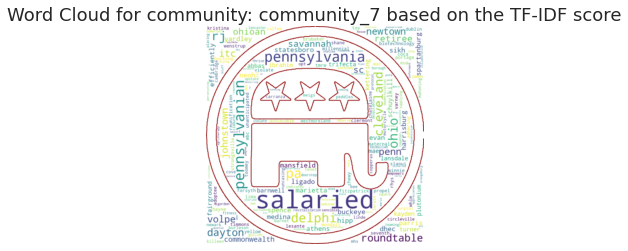

In [155]:
for community in all_com: #loop through each community
    wordcloud = WordCloud(background_color="white", mask=mask_republican, contour_width=3, contour_color='darkred',
               max_font_size=1500, collocations = False).generate(all_com[community])
    plt.figure()
    plt.title("Word Cloud for community: " + str(community) + " based on the TF-IDF score")
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

Let's check in what communities do these people belong to:

In [162]:
# # for i in largest_com_R[0][1]:

# fdist_com  = [] #list with the frequency distribution (term frequency) - the frequency of each token within each community
# tokens_com = {} #dictionary with the unique tokens each community has
# all_tokens = [] #list with all the unique tokens from all the communities



# # for key,value in largest_com_R.items(): #loop through the largest communities
# #     com_name = 'community_'+str(key) #assign to a variable the community name
# #     print(com_name)
# #     tokens = [] #list which will contain the tokens of each community
# #     tokens_com[com_name] = {}
# #     for republican in value[1]:
# #         words = (''.join(Data[Data['TwitterUsernames'] == republican]["Tweets"])).split(' ')
# #         words = [w.lower() for w in words] #all characters are set to lower case
# #         words = [word for word in words if not word.startswith("@")]
# #         words = [word for word in words if not word in pun] #keep only the words which don't contain any of the listed punctuations
# #         words = [word for word in words if word.isalpha()] #keep the words which contain only alphabet letters
# #         words = [w for w in words if not w in stops] #removes the english stop words
# #         words = [w for w in words if not len(w) == 1] #removes the words which have length equal to 1
# #         for word in words: #loop through the list of words
#             # word = lemmatizer.lemmatize(word) #return the lemma of each word
# #             tokens.append(word) #new entry in the tokens list which will be used for the frequency distribution
# #             all_tokens.append(word) #new entry the total token list
                        
# #     tokens_com[com_name] = set(tokens) #add the unique list of tokens in each community
            
# #     fdist_com.append([com_name, nltk.FreqDist(tokens)]) #add the community and the term frequency of each token
                
# # all_tokens = set(all_tokens) #keep the unique tokens
# for com in Dem_and_Rep:
#   tokens = [] #list which will contain the tokens of each community
#   k=0
#   cand_name = 'com'+str(k)
#   k += 1
#   tokens_com[cand_name] = {}
#   for candidate in com:
#     words = (''.join(Data[Data['TwitterUsernames'] == candidate]["Tweets"])).split(' ')
#     words = [w.lower() for w in words] #all characters are set to lower case
#     words = [word for word in words if not word.startswith("@")]
#     words = [word for word in words if not word in pun] #keep only the words which don't contain any of the listed punctuations
#     words = [word for word in words if word.isalpha()] #keep the words which contain only alphabet letters
#     words = [w for w in words if not w in stops] #removes the english stop words
#     words = [w for w in words if not len(w) == 1] #removes the words which have length equal to 1
#     for word in words: #loop through the list of words
#       word = lemmatizer.lemmatize(word) #return the lemma of each word
#       tokens.append(word) #new entry in the tokens list which will be used for the frequency distribution
#       all_tokens.append(word) #new entry the total token list
                          
#     tokens_com[cand_name] = set(tokens) #add the unique list of tokens in each community
              
#     fdist_com.append([cand_name, nltk.FreqDist(tokens)]) #add the community and the term frequency of each token
                
# all_tokens = set(all_tokens) #keep the unique tokens

# import math
# N = len(tokens_com) #total number of communities
# idf = {} #dictionary in which we will have the IDF value for each token

# for token in all_tokens: #loop through all unique tokens
#     count = 0
#     for key in tokens_com.keys(): #loop through each community
#         if [val for val in tokens_com[key]].count(token) > 0: #if the token appears more than once in the current community 
#             count += 1 #the count value will be increased by 1
#             continue
            
#     idf[token] = math.log(N/count) #idf computation based on the above mentioned equation

# tfidf_com = {} #dictionary in which we will have the token and the tfidf
# for dist in fdist_com: #loop through each community
#     tfidf_com[dist[0]] = {}
#     for token in dist[1]: #loop through the tokens of the current community
#         tfidf = dist[1][token] * idf[token] #calculate the tfidf
#         tfidf_com[dist[0]][token] = int(round(tfidf)) #assign the rounded up to the nearest integer value

# all_com = {} #dictionary which will contain the community and its long string

# for com in tfidf_com:
#     all_com[com] = '' #create the community's string
#     for token in tfidf_com[com]: #loop through the token's TF-IDF list values
#         all_com[com] = all_com[com] + (token+' ')*tfidf_com[com][token] #add to the string the repeated tokens

# for community in all_com: #loop through each community
#     wordcloud = WordCloud(background_color="white", mask=mask_democrat, contour_width=3, contour_color='darkred',
#                max_font_size=1500, collocations = False).generate(all_com[community])
#     plt.figure()
#     plt.title("Word Cloud for " + str(community) + " based on the TF-IDF score")
#     plt.imshow(wordcloud, interpolation="bilinear")
#     plt.axis("off")
#     plt.show()

In [54]:
# #lets visualize the communities
# Community_r = nx.Graph()  # load a default graph

# # pos = nx.spring_layout(G)  # compute graph layout
# # plt.figure(figsize=(8, 8))  # image is 8 x 8 inches
# # plt.axis('off')
# # nx.draw_networkx_nodes(G, pos, node_size=600, cmap=plt.cm.RdYlBu, node_color=list(partition_Republican.values()))
# # nx.draw_networkx_edges(G, pos, alpha=0.3)
# # plt.show(G)

# pos = nx.spring_layout(Community_r)  # compute graph layout
# plt.figure(figsize=(10, 10))
# plt.axis('off')
# nx.draw_networkx_nodes(Community_r, pos, node_size=600, cmap=plt.cm.RdYlBu, node_color=list(partition_Republican.values()))
# nx.draw_networkx_edges(Community_r, pos, alpha=0.3)
# plt.show(Community_r)

In [156]:
communities_sorted = {k: v for k, v in sorted(communities_D.items(), key=lambda item: item[1], reverse=True)} #sort the dictionary based on the community size

largest_com_D = {} #create dictionary for the 6 largest communities
c=0
for key, value in communities_sorted.items(): #loop through the items in the sorted list
    if c < 6: #until we have filled the list with the items of the 6 largest community 
        largest_com_D[key] = value
    c += 1

In [157]:
fdist_com  = [] #list with the frequency distribution (term frequency) - the frequency of each token within each community
tokens_com = {} #dictionary with the unique tokens each community has
all_tokens = [] #list with all the unique tokens from all the communities

for key,value in largest_com_D.items(): #loop through the largest communities
    com_name = 'community_'+str(key) #assign to a variable the community name
    print(com_name)
    tokens = [] #list which will contain the tokens of each community
    tokens_com[com_name] = {}
    for democrat in value[1]:
        words = (''.join(Data[Data['TwitterUsernames'] == democrat]["Tweets"])).split(' ')
        words = [w.lower() for w in words] #all characters are set to lower case
        words = [word for word in words if not word.startswith("@")]
        words = [word for word in words if not word in pun] #keep only the words which don't contain any of the listed punctuations
        words = [word for word in words if word.isalpha()] #keep the words which contain only alphabet letters
        words = [w for w in words if not w in stops] #removes the english stop words
        words = [w for w in words if not len(w) == 1] #removes the words which have length equal to 1
        for word in words: #loop through the list of words
            word = lemmatizer.lemmatize(word) #return the lemma of each word
            tokens.append(word) #new entry in the tokens list which will be used for the frequency distribution
            all_tokens.append(word) #new entry the total token list
                        
    tokens_com[com_name] = set(tokens) #add the unique list of tokens in each community
            
    fdist_com.append([com_name, nltk.FreqDist(tokens)]) #add the community and the term frequency of each token
                
all_tokens = set(all_tokens) #keep the unique tokens

community_1
community_2
community_5
community_0
community_6
community_3


In [158]:
N = len(tokens_com) #total number of communities
idf = {} #dictionary in which we will have the IDF value for each token

for token in all_tokens: #loop through all unique tokens
    count = 0
    for key in tokens_com.keys(): #loop through each community
        if [val for val in tokens_com[key]].count(token) > 0: #if the token appears more than once in the current community 
            count += 1 #the count value will be increased by 1
            continue
            
    idf[token] = math.log(N/count) #idf computation based on the above mentioned equation

In [159]:
tfidf_com = {} #dictionary in which we will have the token and the tfidf
for dist in fdist_com: #loop through each community
    tfidf_com[dist[0]] = {}
    for token in dist[1]: #loop through the tokens of the current community
        tfidf = dist[1][token] * idf[token] #calculate the tfidf
        tfidf_com[dist[0]][token] = int(round(tfidf)) #assign the rounded up to the nearest integer value

In [160]:
all_com = {} #dictionary which will contain the community and its long string

for com in tfidf_com:
    all_com[com] = '' #create the community's string
    for token in tfidf_com[com]: #loop through the token's TF-IDF list values
        all_com[com] = all_com[com] + (token+' ')*tfidf_com[com][token] #add to the string the repeated tokens

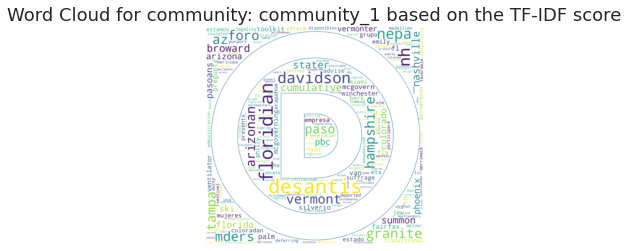

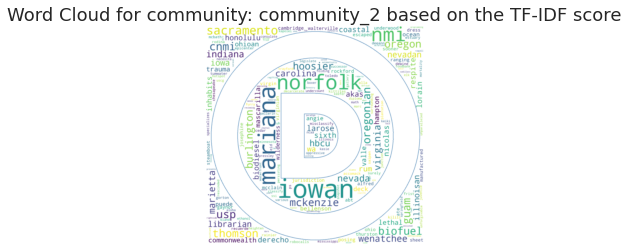

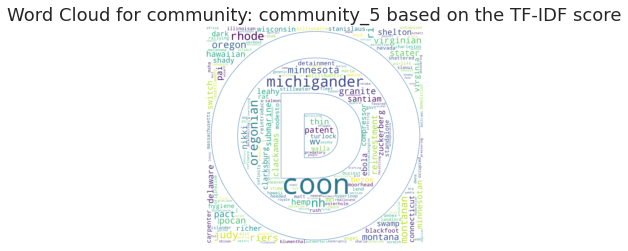

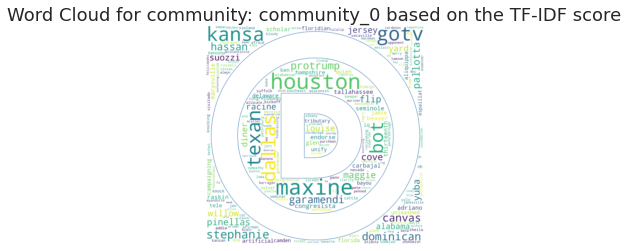

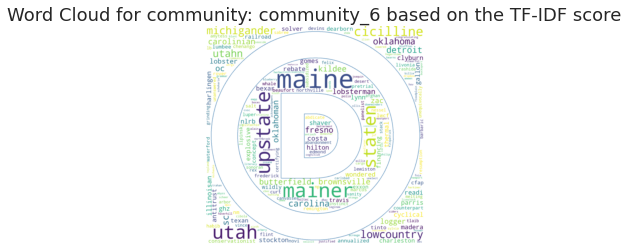

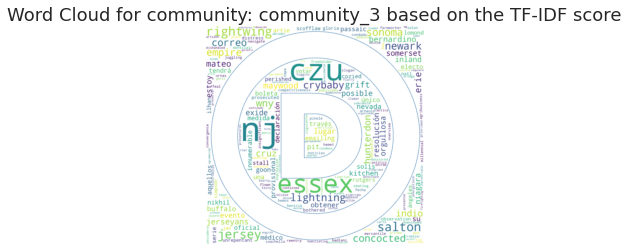

In [161]:
for community in all_com: #loop through each community
    wordcloud = WordCloud(background_color="white", mask=mask_democrat, contour_width=3, contour_color='steelblue',
               max_font_size=1500, collocations = False).generate(all_com[community])
    plt.figure()
    plt.title("Word Cloud for community: " + str(community) + " based on the TF-IDF score")
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [55]:
# #lets visualize the communities
# Community_d = nx.Graph()  # load a default graph

# # pos = nx.spring_layout(G)  # compute graph layout
# # plt.figure(figsize=(8, 8))  # image is 8 x 8 inches
# # plt.axis('off')
# # nx.draw_networkx_nodes(G, pos, node_size=600, cmap=plt.cm.RdYlBu, node_color=list(partition_Republican.values()))
# # nx.draw_networkx_edges(G, pos, alpha=0.3)
# # plt.show(G)

# pos = nx.spring_layout(Community_d)  # compute graph layout
# plt.figure(figsize=(10, 10))
# plt.axis('off')
# nx.draw_networkx_nodes(Community_d, pos, node_size=300, cmap=plt.cm.RdYlBu, node_color=list(partition_Democrat.values()))
# nx.draw_networkx_edges(Community_d, pos, alpha=0.3)
# plt.show(Community_d)

### Most influential politician analysis:

We 'll consider politicians with the most influence based on our analysis. We 'll check one representative from the Democrats and one from the Republicans. 

The two names we are gonna inspect are:
* DougJones (Democrat)
* SebJohnThune (Republican)

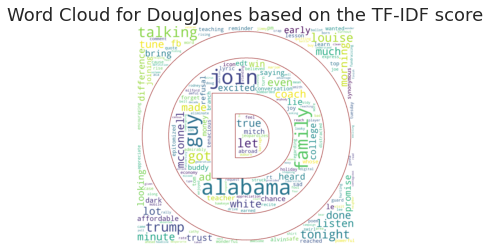

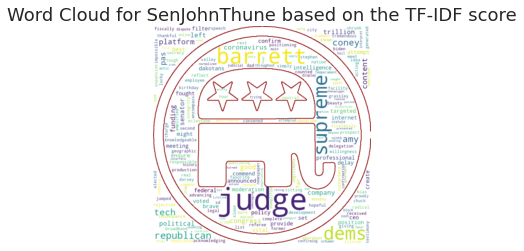

In [165]:
Candidates = ['DougJones', 'SenJohnThune']
  # # for tokens in tokens_com:
# for com, name  in tokens_com.items():  # for name, age in dictionary.iteritems():  (for Python 2.x)
#   if name == 'DougJones':
#     print(com)

fdist_com  = [] #list with the frequency distribution (term frequency) - the frequency of each token within each community
tokens_com = {} #dictionary with the unique tokens each community has
all_tokens = [] #list with all the unique tokens from all the communities

# for key,value in largest_com_R.items(): #loop through the largest communities
#     com_name = 'community_'+str(key) #assign to a variable the community name
#     print(com_name)

    # for republican in value[1]:
for candidate in Candidates:
  tokens = [] #list which will contain the tokens of each community
  cand_name = candidate
  tokens_com[cand_name] = {}
  words = (''.join(Data[Data['TwitterUsernames'] == candidate]["Tweets"])).split(' ')
  words = [w.lower() for w in words] #all characters are set to lower case
  words = [word for word in words if not word.startswith("@")]
  words = [word for word in words if not word in pun] #keep only the words which don't contain any of the listed punctuations
  words = [word for word in words if word.isalpha()] #keep the words which contain only alphabet letters
  words = [w for w in words if not w in stops] #removes the english stop words
  words = [w for w in words if not len(w) == 1] #removes the words which have length equal to 1
  for word in words: #loop through the list of words
    word = lemmatizer.lemmatize(word) #return the lemma of each word
    tokens.append(word) #new entry in the tokens list which will be used for the frequency distribution
    all_tokens.append(word) #new entry the total token list
                        
  tokens_com[cand_name] = set(tokens) #add the unique list of tokens in each community
            
  fdist_com.append([cand_name, nltk.FreqDist(tokens)]) #add the community and the term frequency of each token
                
all_tokens = set(all_tokens) #keep the unique tokens

import math
N = len(tokens_com) #total number of communities
idf = {} #dictionary in which we will have the IDF value for each token

for token in all_tokens: #loop through all unique tokens
    count = 0
    for key in tokens_com.keys(): #loop through each community
        if [val for val in tokens_com[key]].count(token) > 0: #if the token appears more than once in the current community 
            count += 1 #the count value will be increased by 1
            continue
            
    idf[token] = math.log(N/count) #idf computation based on the above mentioned equation

tfidf_com = {} #dictionary in which we will have the token and the tfidf
for dist in fdist_com: #loop through each community
    tfidf_com[dist[0]] = {}
    for token in dist[1]: #loop through the tokens of the current community
        tfidf = dist[1][token] * idf[token] #calculate the tfidf
        tfidf_com[dist[0]][token] = int(round(tfidf)) #assign the rounded up to the nearest integer value

all_com = {} #dictionary which will contain the community and its long string

for com in tfidf_com:
    all_com[com] = '' #create the community's string
    for token in tfidf_com[com]: #loop through the token's TF-IDF list values
        all_com[com] = all_com[com] + (token+' ')*tfidf_com[com][token] #add to the string the repeated tokens

for community in all_com: #loop through each community
  if community == 'DougJones':
    wordcloud = WordCloud(background_color="white", mask=mask_democrat, contour_width=3, contour_color='darkred',
               max_font_size=1500, collocations = False).generate(all_com[community])
    plt.figure()
    plt.title("Word Cloud for " + str(community) + " based on the TF-IDF score")
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
  else:
    wordcloud = WordCloud(background_color="white", mask=mask_republican, contour_width=3, contour_color='darkred',
               max_font_size=1500, collocations = False).generate(all_com[community])
    plt.figure()
    plt.title("Word Cloud for " + str(community) + " based on the TF-IDF score")
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


In [163]:
for key,value in largest_com_D.items():
  for democrat in value[1]:
    if democrat == 'DougJones':
      print(f"{democrat} belogns to the community {key}\n")
  
for key,value in largest_com_R.items():
  #print(key, value)
  for republican in value[1]:
    if republican == 'SenJohnThune':
      print(f"{republican} belogns to the community {key}")

DougJones belogns to the community 0

SenJohnThune belogns to the community 0


In [169]:
Rep = []
for i in largest_com_R[0][1]:
  if i != 'SenJohnThune':
    Rep.append(i)

Dem = []
for k in largest_com_D[0][1]:
  if k != 'DougJones':
     Dem.append(k)

In [175]:
Dem[1]

'RepTerriSewell'

In [179]:
print(N)

2


In [238]:
makedict = {
    '0' : Dem,
    '1' : Rep
}

In [203]:
largest_com_D.keys()

dict_keys([1, 2, 5, 0, 6, 3])

In [239]:
for i in list(makedict.values())[0]:
  print(i)

KamalaHarris
RepTerriSewell
repjohnlewis
RepDelBene
RepDavids
RepVeasey
RepJohnYarmuth
RepGaramendi
RepConorLamb
JacksonLeeTX18
RepHankJohnson
RepBryanSteil
CarbajalSalud
RepSylviaGarcia
MaxineWaters
Nanette4CA
MichaelBennet
RepEBJ
amyklobuchar
CatherineForNV
CoryBooker
LisaBRochester
SanfordBishop
AlLawsonJr
SMurphyCongress
Val_Demings
CharlieCrist
repdavidscott
RepRonKind
repcleaver
Jamie_Raskin
PramilaJayapal
RepColinAllred
RepCuellar
RepFletcher
Maggie_Hassan
DonNorcross4NJ
JoshGottheimer
RepGonzalez
Tom_Suozzi
EspaillatNY
RepRickLarsen


In [230]:
for key,value in makedict.items(): #loop through the largest communities
    com_name = 'community_'+str(key) #assign to a variable the community name
    print(com_name)
    tokens = [] #list which will contain the tokens of each community
    tokens_com[com_name] = {}
    #for dem in value[1]:
      #print(dem)

community_Democrats
community_Republicans


In [243]:
fdist_com  = [] #list with the frequency distribution (term frequency) - the frequency of each token within each community
tokens_com = {} #dictionary with the unique tokens each community has
all_tokens = [] #list with all the unique tokens from all the communities

for key,value in makedict.items(): #loop through the largest communities
    com_name = 'community_'+str(key) #assign to a variable the community name
    tokens = [] #list which will contain the tokens of each community
    tokens_com[com_name] = {}
    for i in list(makedict.values())[0]:
        words = (''.join(Data[Data['TwitterUsernames'] == democrat]["Tweets"])).split(' ')
        words = [w.lower() for w in words] #all characters are set to lower case
        words = [word for word in words if not word.startswith("@")]
        words = [word for word in words if not word in pun] #keep only the words which don't contain any of the listed punctuations
        words = [word for word in words if word.isalpha()] #keep the words which contain only alphabet letters
        words = [w for w in words if not w in stops] #removes the english stop words
        words = [w for w in words if not len(w) == 1] #removes the words which have length equal to 1
        for word in words: #loop through the list of words
            word = lemmatizer.lemmatize(word) #return the lemma of each word
            tokens.append(word) #new entry in the tokens list which will be used for the frequency distribution
            all_tokens.append(word) #new entry the total token list
                        
    tokens_com[com_name] = set(tokens) #add the unique list of tokens in each community
    print(tokens_com)        
    fdist_com.append([com_name, nltk.FreqDist(tokens)]) #add the community and the term frequency of each token
                
all_tokens = set(all_tokens) #keep the unique tokens

import math
N = len(tokens_com) #total number of communities
idf = {} #dictionary in which we will have the IDF value for each token

for token in all_tokens: #loop through all unique tokens
    count = 0
    for key in tokens_com.keys(): #loop through each community
        if [val for val in tokens_com[key]].count(token) > 0: #if the token appears more than once in the current community 
            count += 1 #the count value will be increased by 1
            continue
            
    idf[token] = math.log(N/count) #idf computation based on the above mentioned equation

tfidf_com = {} #dictionary in which we will have the token and the tfidf
for dist in fdist_com: #loop through each community
    tfidf_com[dist[0]] = {}
    for token in dist[1]: #loop through the tokens of the current community
        tfidf = dist[1][token] * idf[token] #calculate the tfidf
        tfidf_com[dist[0]][token] = int(round(tfidf)) #assign the rounded up to the nearest integer value

all_com = {} #dictionary which will contain the community and its long string

for com in tfidf_com:
    all_com[com] = '' #create the community's string
    for token in tfidf_com[com]: #loop through the token's TF-IDF list values
        all_com[com] = all_com[com] + (token+' ')*tfidf_com[com][token] #add to the string the repeated tokens

for community in all_com: #loop through each community
    wordcloud = WordCloud(background_color="white", mask=mask_democrat, contour_width=3, contour_color='darkred',
               max_font_size=1500, collocations = False).generate(all_com['community_Republicans'])
    plt.figure()
    plt.title("Word Cloud for " + str(community) + " based on the TF-IDF score")
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

{'community_0': set()}
{'community_0': set(), 'community_1': set()}


KeyError: ignored

In [212]:
for comm in all_com:
  print(comm)

community_Democrats
community_Republicans


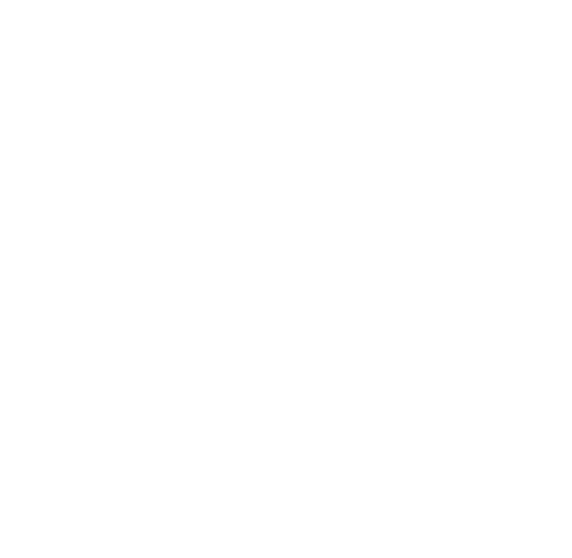

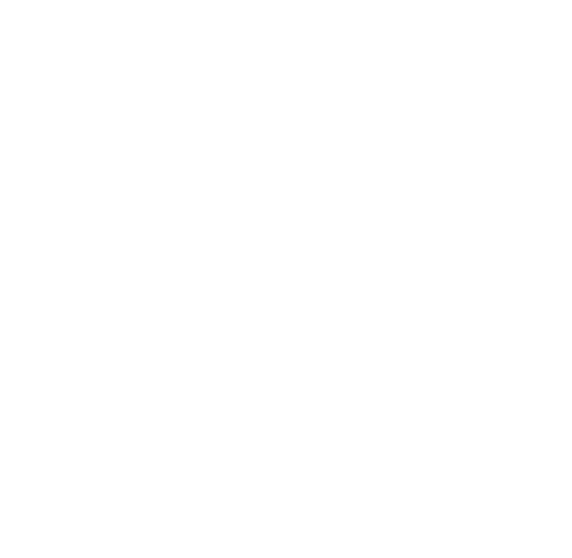

In [ ]:
node_size = []

H = nx.Graph()

# first community against the others
for node, community in partition_Democrat.items():
    if community == 1:
        node_size.append(900)
    else:
        partition_Democrat[node] = 0  # I put all the other communities in one communitiy
        node_size.append(300)

plt.figure(figsize=(10, 10))
plt.axis('off')
nodes = nx.draw_networkx_nodes(H, pos, node_size=node_size, cmap=plt.cm.winter, node_color=list(partition_Democrat.values()))
nx.draw_networkx_edges(H, pos, alpha=0.3)
plt.show(H)